In [1]:
# pylint: disable=invalid-name
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fractions import Fraction
from numpy.random import randint

# Imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler


## 1. El Problema: Encontrar el Período

Analicemos la función periódica:

$$ f(x) = a^x \bmod{N} $$

<details>
<summary>Recordatorio: Operación Módulo y Aritmética Modular (Haz clic aquí para expandir)</summary>

La operación módulo (abreviada como "mod") significa simplemente encontrar el residuo al dividir un número por otro. Por ejemplo:

$$ 17 \bmod 5 = 2 $$

Esto se debe a que $ 17 \div 5 = 3 $ con residuo $ 2 $. (es decir, $ 17 = (3 \times 5) + 2 $). En Python, la operación módulo se denota con el símbolo <code>%</code>.

Este comportamiento se utiliza en la [aritmética modular](https://es.wikipedia.org/wiki/Aritm%C3%A9tica_modular), donde los números "se reinician" después de alcanzar un cierto valor (el módulo). Usando aritmética modular, podríamos escribir:

$$ 17 = 2 \pmod 5 $$

Nota que aquí el $\pmod 5$ se aplica a toda la ecuación (ya que está entre paréntesis), a diferencia de la ecuación anterior, donde solo se aplica al lado izquierdo de la ecuación.

</details>

Donde $ a $ y $ N $ son enteros positivos, $ a $ es menor que $ N $, y no tienen factores comunes. El período, o "orden" ($ r $), es el menor entero positivo ($ r > 0 $) tal que:

$$ a^r \bmod N = 1 $$ 

Podemos observar un ejemplo de esta función representado en el siguiente gráfico. Nota que las líneas entre los puntos ayudan a visualizar la periodicidad, pero no representan los valores intermedios entre los marcadores $ x $.


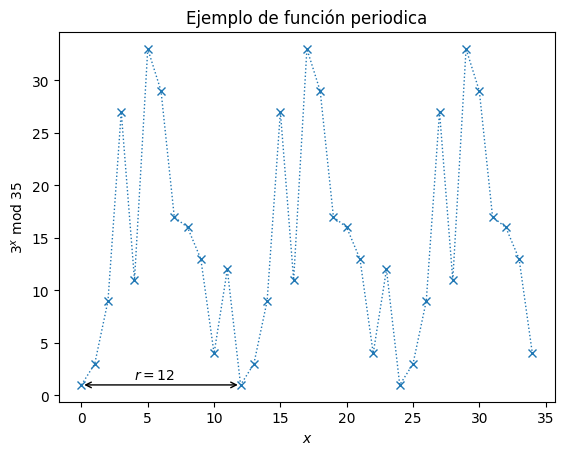

In [26]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Ejemplo de función periodica")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('No pudo encontrar el período, verificar a <n y no tener factores comunes.')

## 2. La Solución

La solución de Shor fue utilizar la [estimación de fase cuántica](./quantum-phase-estimation.html) sobre el operador unitario:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

Para entender cómo esto es útil, calculemos cómo podría ser un estado propio de $ U $. Si comenzamos en el estado $ |1\rangle $, podemos ver que cada aplicación sucesiva de $ U $ multiplicará el estado de nuestro registro por $ a \pmod N $, y después de $ r $ aplicaciones volveremos al estado $ |1\rangle $. Por ejemplo, con $ a = 3 $ y $ N = 35 $:

$$
\begin{aligned}
U|1\rangle &= |3\rangle \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}
$$


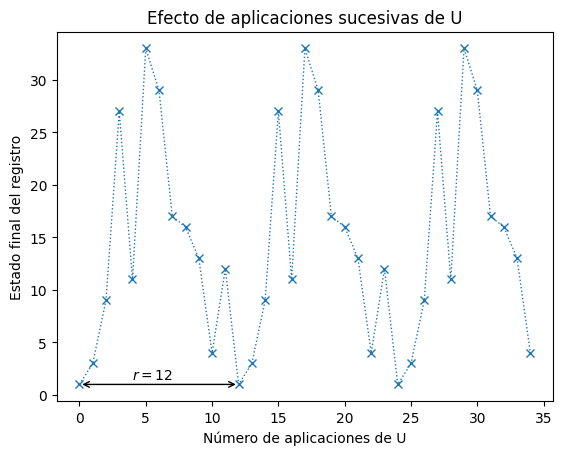

In [3]:
ax.set(xlabel='Número de aplicaciones de U',
       ylabel='Estado final del registro',
       title="Efecto de aplicaciones sucesivas de U")
fig

Entonces, una superposición de los estados en este ciclo $( |u_0\rangle )$ sería un estado propio de $ U $:

$$ |u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$

<details>
<summary>Haz clic para expandir: Ejemplo con $ a = 3 $ y $ N = 35 $</summary>

$$
\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}
$$
</details>

Este estado propio tiene un valor propio de 1, lo cual no es muy interesante. Un estado propio más interesante sería uno en el que la fase sea diferente para cada uno de estos estados de la base computacional. Específicamente, veamos el caso en el que la fase del $ k^\text{th} $ estado sea proporcional a $ k $:

$$
\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

<details>
<summary>Haz clic para expandir: Ejemplo con $ a = 3 $ y $ N = 35 $</summary>

$$
\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}
$$

(Podemos observar que $ r = 12 $ aparece en el denominador de la fase).
</details>

Este es un valor propio particularmente interesante porque contiene $ r $. De hecho, $ r $ debe incluirse para asegurar que las diferencias de fase entre los $ r $ estados de la base computacional sean iguales. Este no es el único estado propio con este comportamiento; para generalizar esto, podemos multiplicar un entero, $ s $, a esta diferencia de fase, lo cual aparecerá en nuestro valor propio:

$$
\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

<details>
<summary>Haz clic para expandir: Ejemplo con  a = 3  y  N = 35 </summary>

$$
\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}
$$
</details>

Ahora tenemos un estado propio único para cada valor entero de $ s $ donde $ 0 \leq s \leq r-1 $. De manera conveniente, si sumamos todos estos estados propios, las diferentes fases cancelan todos los estados de la base computacional excepto $ |1\rangle $:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle $$

<details>
<summary>Haz clic para expandir: Ejemplo con  a = 7  y  N = 15 </summary>

Para este caso, observemos un ejemplo más pequeño donde $ a = 7 $ y $ N=15 $. Aquí $ r=4 $:

$$
\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle + |7\rangle + |4\rangle + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{4\pi i}{4}}|4\rangle + e^{-\tfrac{6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}
$$
</details>

Dado que el estado de la base computacional $ |1\rangle $ es una superposición de estos estados propios, esto significa que si realizamos **QPE** sobre $ U $ usando el estado $ |1\rangle $, mediremos una fase:

$$\phi = \frac{s}{r}$$

Donde $ s $ es un entero aleatorio entre $ 0 $ y $ r-1 $. Finalmente, usamos el algoritmo de [fracciones continuas](https://es.wikipedia.org/wiki/Fracci%C3%B3n_continua) sobre $ \phi $ para encontrar $ r $. 

A continuación, demostraremos el algoritmo de Shor utilizando los simuladores de Qiskit. Para esta demostración proporcionaremos los circuitos para $ U $ sin explicación, pero en la sección 4 discutiremos cómo construir eficientemente los circuitos para $ U^{2^j} $.


In [4]:
def c_amod15(a, power):
    """Multiplicacion  controlada por a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [5]:
# Especificacion de variables 
N_COUNT = 8  # Numero de qbits para contar
a = 7

In [6]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

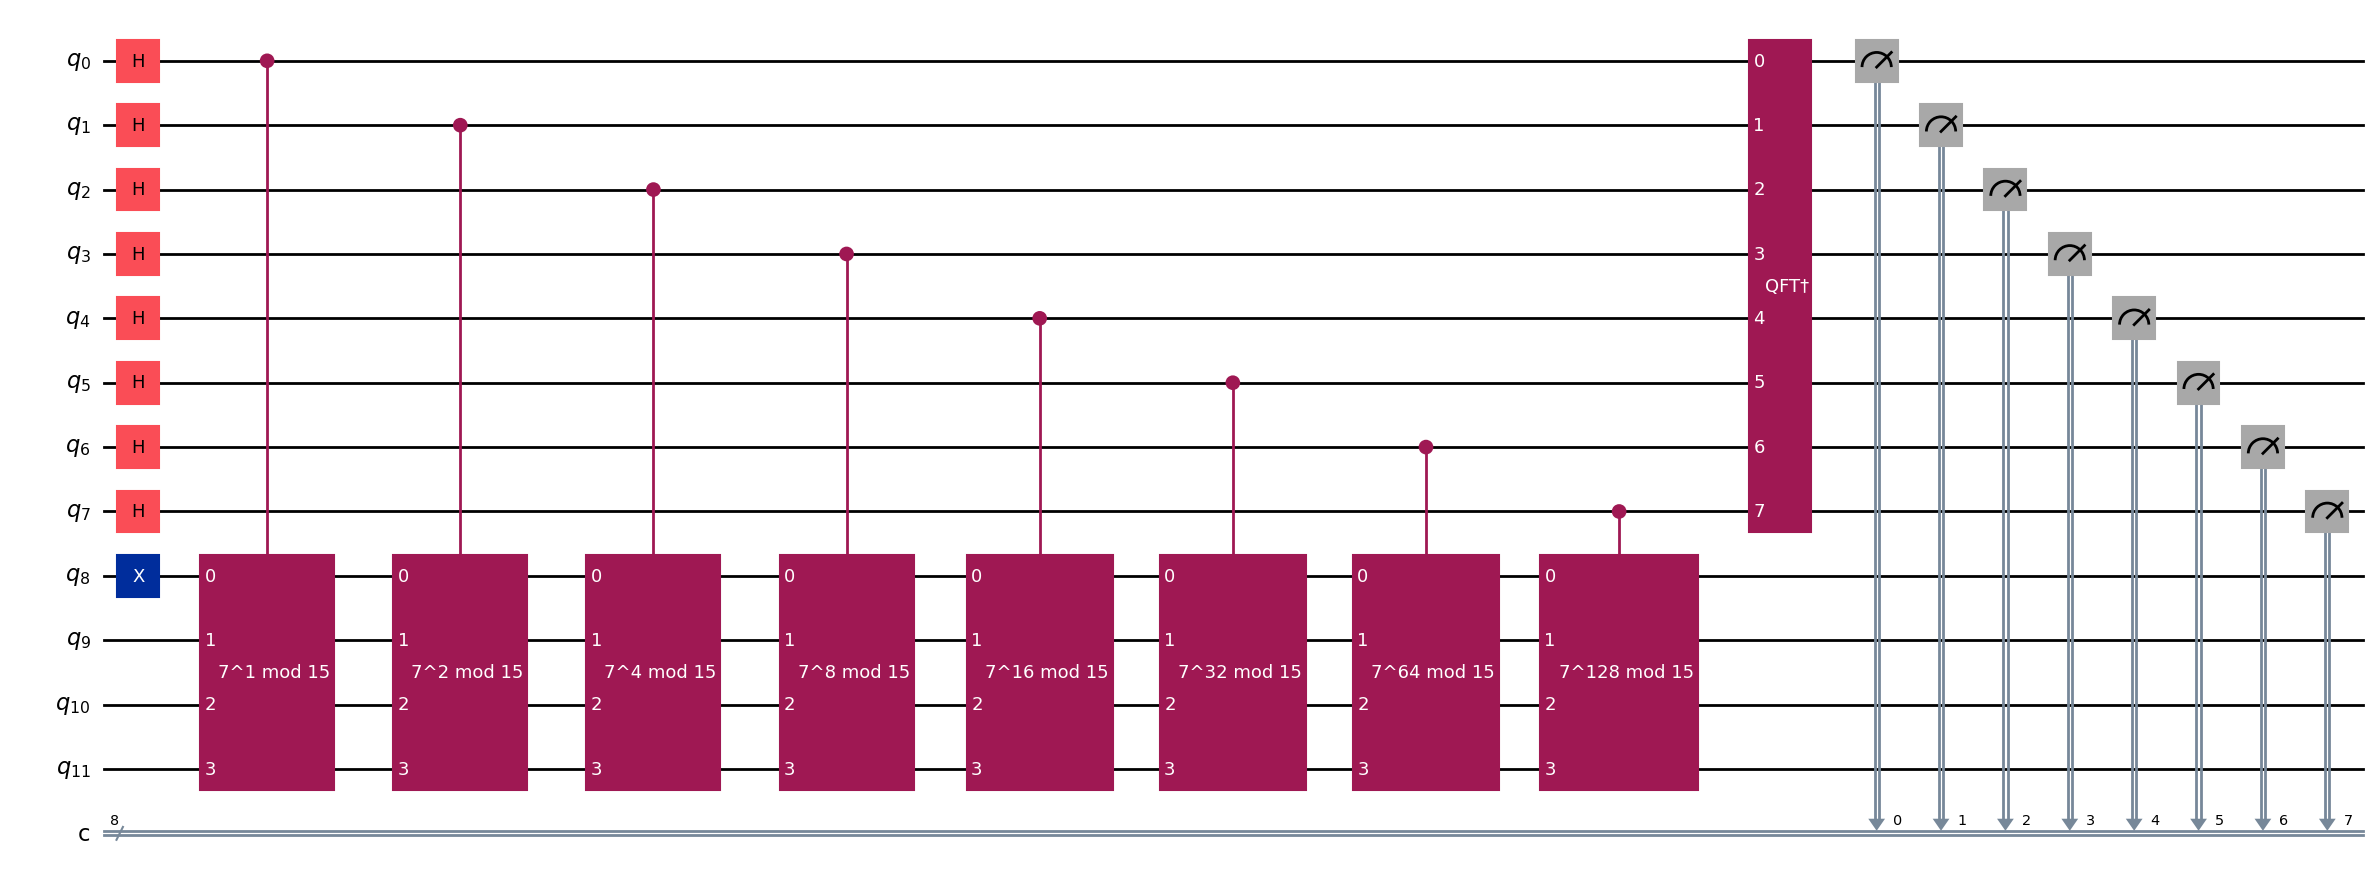

In [7]:
# CRear circuito cuantico de conteo
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Inicializar qubits de conteo en el estado |+>
for q in range(N_COUNT):
    qc.h(q)

# Aplicar el estado |1> al qubit auxiliar
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1, output='mpl')  # -1 means 'do not fold'

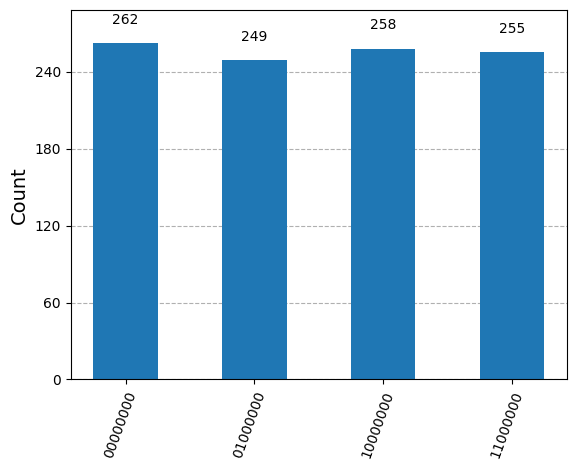

In [8]:
aer_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convertir binario a decimal
    phase = decimal/(2**N_COUNT)  # Encontrar el valor de la fase
    measured_phases.append(phase)
    # Añadir el resultado a la lista de filas
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Impresion de los resultados
headers=["Registro de salida", "Fase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

         Registro de salida            Fase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  10000000(bin) = 128(dec)  128/256 = 0.50
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


Ahora podemos usar el algoritmo de fracciones continuas para intentar encontrar $ s $ y $ r $. Python tiene esta funcionalidad incorporada: podemos usar el módulo `fractions` para convertir un número decimal en un objeto `Fraction`. Por ejemplo:


In [10]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Debido a que esto proporciona fracciones que representan exactamente el resultado (en este caso, `0.6660000...`), puede generar resultados complejos como el mostrado anteriormente. Podemos usar el método `.limit_denominator()` para obtener la fracción que más se asemeja a nuestro número decimal, con un denominador por debajo de un cierto valor:


In [11]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

¡Mucho mejor! El orden ($ r $) debe ser menor que $ N $, por lo que estableceremos el denominador máximo en `15`:


In [12]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Fase", "Fracción", "r propuesto"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Fase Fracción  r propuesto
0  0.75      3/4            4
1  0.50      1/2            2
2  0.25      1/4            4
3  0.00      0/1            1


Podemos ver que dos de los valores propios medidos nos proporcionaron el resultado correcto: $ r = 4 $, y podemos observar que el algoritmo de Shor tiene una posibilidad de fallar. Estos resultados incorrectos se deben a que $ s = 0 $, o a que $ s $ y $ r $ no son coprimos, y en lugar de $ r $, obtenemos un factor de $ r $. La solución más simple para esto es simplemente repetir el experimento hasta obtener un resultado satisfactorio para $ r $.

### Pregunta

- Cambia el circuito anterior para los valores de $ a = 2, 8, 11 $ y $ 13 $. ¿Qué resultados obtienes y por qué?


## 4. Exponenciación Modular

Habrás notado que el método de crear las puertas $ U^{2^j} $ repitiendo $ U $ crece exponencialmente con $ j $ y no resultará en un algoritmo de tiempo polinómico. Queremos una forma de crear el operador:

$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$

que crezca de manera polinómica con $ j $. Afortunadamente, calcular:

$$ a^{2^j} \bmod N $$

de manera eficiente es posible. Las computadoras clásicas pueden usar un algoritmo conocido como _exponenciación rápida_ o _repeated squaring_ para calcular un exponencial. En nuestro caso, dado que solo estamos tratando con exponenciales de la forma $ 2^j $, el algoritmo de exponenciación rápida se simplifica mucho:


In [13]:
def a2jmodN(a, j, N):
    """
    Calcula a^{2^j} (mod N) usando cuadrados repetidos.

    Parámetros:
    a (int): El número base.
    j (int): El exponente al que se eleva 2.
    N (int): El módulo.

    Retorna:
    int: El resultado de a^{2^j} (mod N).
    """
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

Si un algoritmo eficiente es posible en Python, entonces podemos usar el mismo algoritmo en una computadora cuántica. Desafortunadamente, a pesar de escalar de manera polinómica con $ j $, los circuitos de exponenciación modular no son sencillos y representan el cuello de botella en el algoritmo de Shor. Una implementación amigable para principiantes se puede encontrar en la referencia [1].

## 5. Factorización a partir de la Búsqueda de Períodos

No todos los problemas de factorización son difíciles; podemos identificar un número par al instante y saber que uno de sus factores es 2. De hecho, existen [criterios específicos](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf#%5B%7B%22num%22%3A127%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C70%2C223%2C0%5D) para elegir números que sean difíciles de factorizar, pero la idea básica es elegir el producto de dos números primos grandes.

Un algoritmo general de factorización primero verificará si hay un atajo para factorizar el entero (¿es el número par? ¿Es el número de la forma $ N = a^b $?), antes de usar la búsqueda de períodos de Shor para el caso peor. Dado que nuestro objetivo es enfocarnos en la parte cuántica del algoritmo, iremos directamente al caso en el que $ N $ es el producto de dos números primos.

### Ejemplo: Factorizar 15

Para ver un ejemplo de factorización con un pequeño número de qubits, factorizaremos 15, que todos sabemos es el producto de los números primos no tan grandes 3 y 5.


In [14]:
# Funcion 
N = 15

In [15]:
a = 7

Luego verificamos rápidamente que $ a $ no sea ya un factor no trivial de $ N $:

In [16]:
from math import gcd # greatest common divisor
gcd(a, N)

1

Genial. A continuación, realizamos el algoritmo de búsqueda de períodos de Shor para $ a = 12 $ y $ N = 15 $. Recuerda que la fase que medimos será $ s/r $, donde:

$$ a^r \bmod N = 1 $$

y $ s $ es un entero aleatorio entre 0 y $ r-1$.


In [17]:
def qpe_amod15(a):
    """Realiza una estimación de fase cuántica en la operación A*r mod 15.
    Args:
    A (int): esto es 'a' en un*r mod 15
    Devoluciones:
    flotante: estimación de la fase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Inicializar qubits de conteo en el estado |+>
    qc.x(N_COUNT) # registro auxiliar en el estado |1>
    for q in range(N_COUNT): # Operaciones controladas de U
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # QFT†
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simular los resultados
    aer_sim = Aer.get_backend('qasm_simulator')
    # `memory=True` le dice al backend que guarde cada medida en una lista
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Lectura de registros: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Fase: {phase}")
    return phase

De esta fase, podemos encontrar fácilmente una suposición por $r$:

In [18]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

Lectura de registros: 10000000
Fase: 0.5


Fraction(1, 2)

In [22]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(s, r)

1 2


Ahora tenemos $ r $, podríamos usar esto para encontrar un factor de $ N $. Desde:

$$ a^r \bmod n = 1 $$

entonces:

$$ (a^r - 1) \bmod n = 0 $$

lo que significa $ n $ debe dividir $ a^r-1 $. Y si $ r $ también es uniforme, entonces podemos escribir:

$$ a^r -1 = (a^{r/2} -1) (a^{r/2} +1) $$

(Si $ r $ no es uniforme, no podemos ir más allá y debemos intentarlo nuevamente con un valor diferente por $ a $). Entonces existe una alta probabilidad de que el mayor divisor común de $ n $ y $ a^{r/2} -1 $, o $ a^{r/2}+1 $ es un factor adecuado de $ n $ [ 2]:

In [23]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 1]


La celda a continuación repite el algoritmo hasta que se encuentra al menos un factor de 15. Debes intentar volver a ejecutar la celda varias veces para ver cómo se comporta.

In [24]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\INTENTO {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Resultado: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Factores propuestos: {guesses[0]} y {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Factor no trivial encontrado: {guess} ***")
                FACTOR_FOUND = True

\INTENTO 1:
Lectura de registros: 00000000
Fase: 0.0
Resultado: r = 1
\INTENTO 2:
Lectura de registros: 00000000
Fase: 0.0
Resultado: r = 1
\INTENTO 3:
Lectura de registros: 11000000
Fase: 0.75
Resultado: r = 4
Factores propuestos: 3 y 5
*** Factor no trivial encontrado: 3 ***
*** Factor no trivial encontrado: 5 ***


## 6. Referencias

1. Stephane Beauregard, _Circuit for Shor's algorithm using 2n+3 qubits,_ [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, _Quantum Computation and Quantum Information,_ Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)